In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns

np.random.seed(41)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.set_figure_params(figsize=None)

In [2]:
# Read pre-processed data
save_file = "../data/results/scanpy_preprocess_classification.h5ad"
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 5594 × 3066
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


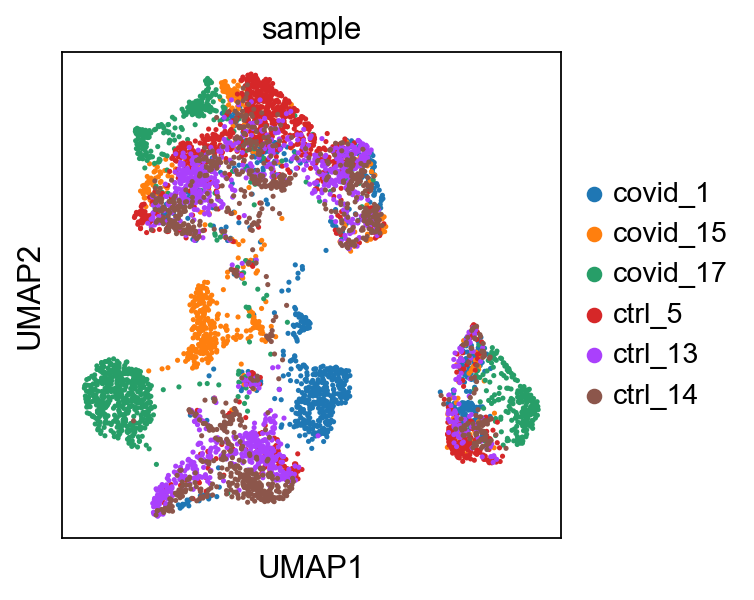

In [3]:
sc.pl.umap(adata, color="sample")

### Test using sklearn.neighbors.NearestCentroid to get a centroid of each cluster

[1]


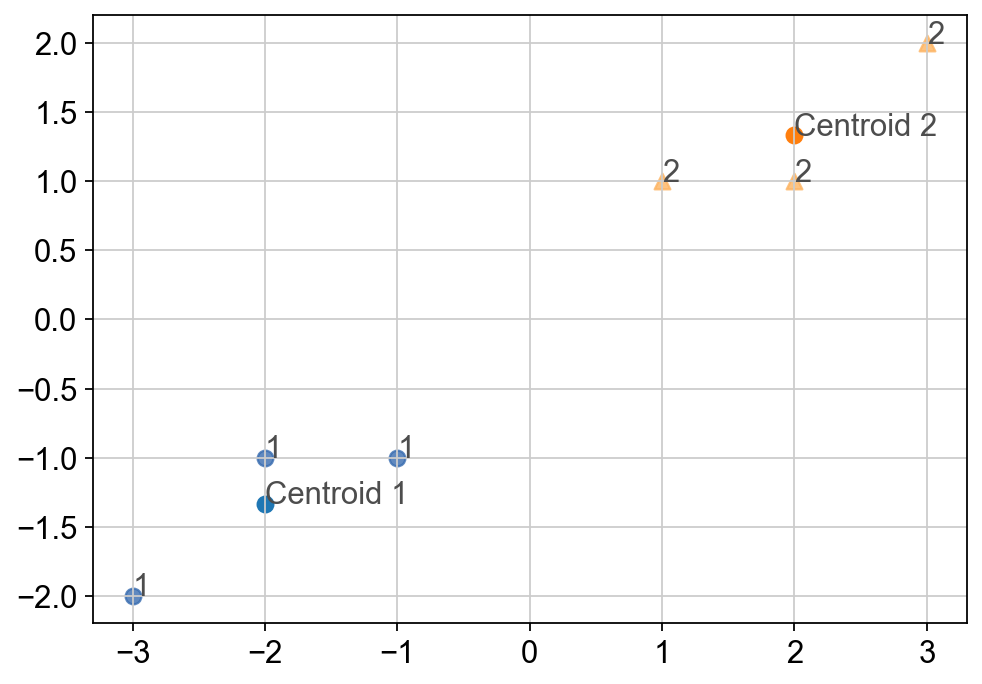

In [4]:
COLORS = ["#386cb0", "#fdb462"]
MARKERS = ["o", "^"]  # circle, triangle
GREY30 = "#4d4d4d"

# Test for getting centroids of each cluster
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))


X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
clf = NearestCentroid()

clf.fit(X, y)

print(clf.predict([[-0.8, -1]]))

for x, y in zip(X, y):
    if y == 1:
        ax.scatter(x[0], x[1], s=50, color=COLORS[0], marker=MARKERS[0], alpha=0.8)
        ax.text(x[0], x[1], "1", color=GREY30, fontsize=14)
    else:
        ax.scatter(x[0], x[1], s=50, color=COLORS[1], marker=MARKERS[1], alpha=0.8)
        ax.text(x[0], x[1], "2", color=GREY30, fontsize=14)

centroid_id = 1
for centroid in clf.centroids_:
    ax.scatter(centroid[0], centroid[1], s=50)
    ax.text(centroid[0], centroid[1], f"Centroid {centroid_id}", color=GREY30, fontsize=14)
    centroid_id += 1

### Get centroids of each samples

In [5]:
basis_values = adata.obsm["X_umap"]
sample_vector = adata.obs["sample"].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(
    list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
    columns=["basis_value", "sample", "x_basis_value", "y_basis_value"],
)
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df["sample"].tolist()
clf = NearestCentroid()
clf.fit(X, y)

# print("Centroids:", clf.centroids_)

NearestCentroid()

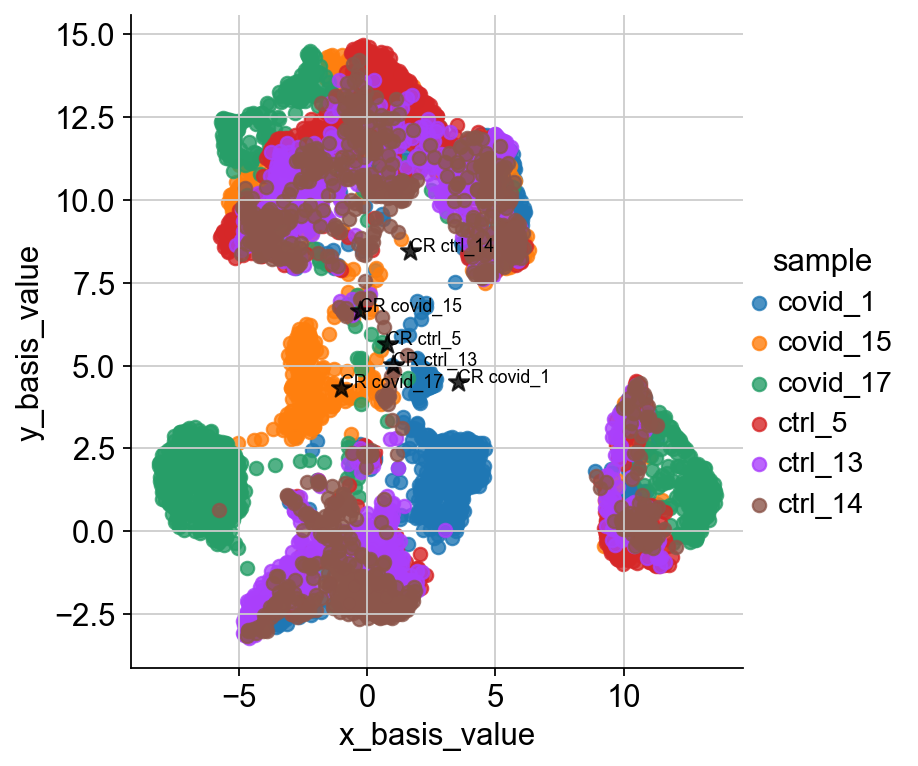

<Figure size 1120x1120 with 0 Axes>

In [7]:
list_samples = df["sample"].unique()
# sns.scatterplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample')
sns.lmplot(x="x_basis_value", y="y_basis_value", data=df, hue="sample", fit_reg=False)

centroid_id = 0
for centroid in clf.centroids_:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color="black")
    plt.text(centroid[0], centroid[1], f"CR {list_samples[centroid_id]}", color="black", fontsize=8)
    centroid_id += 1

# Show the plot
plt.figure(figsize=(14, 14))
plt.savefig("../output_pdfs/GSE159812_samples_centroids.pdf", format="pdf")

## Sample Classification: Scenario 2.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, count the nearest centroids of each cell in a new sample. And make a result based on the count (either `covid` or `non_covid`)

### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.

In [99]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=10)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)  # 4 samples
print("Samples for testing:", y_test)  # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['covid_1' 'ctrl_5' 'ctrl_13' 'covid_15']
Samples for testing: ['covid_17' 'ctrl_14']


In [112]:
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
# df_exist

Get centroids of each existing samples.

In [109]:
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist["sample"].tolist()
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid()

Get the nearest centroids with new samples.

In [160]:
y_test = list(y_test)
df_new = df.query("sample == @y_test")
# df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new["sample"].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

Count how many the nearest centroids of covid sample/non-covid samples has the new sample obtained.

In [161]:
from collections import Counter

beginning = 0
samples_range = dict()

y_pred_agg = []
y_true_agg = []
for sample in df_new["sample"].unique():
    # Assing a new label (either covid or non_covid sample))
    if "covid" in sample or "COVID" in sample:
        y_true_agg.append("covid")
    else:
        y_true_agg.append("non_covid")
    samples_range[sample] = [beginning, beginning + len(df_new[df_new["sample"] == sample].index.to_list())]
    beginning = len(df_new[df_new["sample"] == sample].index.to_list()) + beginning


# Get count of each new samples
for s, r in samples_range.items():
    print(f"Testing {s}")
    tmp_y_pred = y_pred[r[0] : r[1]]
    # count_detected_samples_key = list(Counter(tmp_y_pred).keys())
    # count_detected_samples = list(Counter(tmp_y_pred).values())
    count_pred_samples = Counter(tmp_y_pred)

    covid_sample_counter = 0
    non_covid_sample_counter = 0
    for s, count in count_pred_samples.items():
        if "covid" in s or "COVID" in s:
            covid_sample_counter += count
        else:
            non_covid_sample_counter += count

    if covid_sample_counter > non_covid_sample_counter:
        y_pred_agg.append("covid")
    else:
        y_pred_agg.append("non_covid")

Testing covid_17
Testing ctrl_14


In [162]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_true_agg, y_pred_agg))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_true_agg, y_pred_agg, average="micro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_true_agg, y_pred_agg, average="micro"))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


## Sample Classification: Scenario 2.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids and then get distances between those existing samples and new samples. Then, sum the distances to the centroid of each new sample and the centroid of coronal and non-corona existing samples, separately for corona and non-corona. <br>
In the end, determine either the new sample is `covid` or `non_covid` based on the total distance with respect to covid and non-covid samples.

In [192]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

Calculate distance between new sample's centroids and exisitng one

In [196]:
print(exist_sample_centroids)
print()
print(new_sample_centroids)

[[ 3.55276108  4.48861408]
 [-0.30881128  6.64485598]
 [ 0.77063167  5.63875961]
 [ 1.66651762  8.45004272]]

[[-1.01623392  4.3340416 ]
 [ 1.00493264  5.00510073]]


In [227]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist["sample"].unique()

list_new_sample = df_new["sample"].unique()
# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    # sample_key = list_exist_sample[i]
    for j in range(len(new_sample_centroids)):
        sample = list_new_sample[j]
        print("sample:", list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: covid_1
sample: covid_17
4.57160890212232
sample: ctrl_14
2.599651552221833
---------------------
Exist sample: covid_15
sample: covid_17
2.416673312407277
sample: ctrl_14
2.1011235950704674
---------------------
Exist sample: ctrl_5
sample: covid_17
2.2125048585882823
sample: ctrl_14
0.6755890235764025
---------------------
Exist sample: ctrl_13
sample: covid_17
4.913107072012502
sample: ctrl_14
3.507893961235966


Get a label from checking the total distance of summing up the distance of exist covid sample and non covid sample between each ewn sample. <br>
<br>
And if the total distance to centroid with corona patient < the total distance to centroid with non corona patient<br>
-> The new sample is Corona (because the centroid of the new sample should be closer with the existing covid samples).<br>
Otherwise, The new sample is Non-covid.

In [244]:
covid_dist_total = 0
non_covid_dist_total = 0


new_dist_total = {s: {"covid": 0, "non_covid": 0} for s in list_new_sample}

for i in range(len(list_exist_sample)):
    exist_sample = list_exist_sample[i]
    for new_s in dict_dist_results.keys():
        dist = dict_dist_results[new_s][i]
        if "covid" in exist_sample or "COVID" in exist_sample:
            new_dist_total[new_s]["covid"] += dist
        else:
            new_dist_total[new_s]["non_covid"] += dist

y_true_total_dist = []
y_pred_total_dist = []

for new_s, dist_total in new_dist_total.items():
    if "covid" in new_s or "COVID" in new_s:
        y_true_total_dist.append("covid")
    else:
        y_true_total_dist.append("non_covid")

    # Compare the total distance to centroid with corona & non corona samples
    if dist_total["covid"] < dist_total["non_covid"]:
        y_pred_total_dist.append("covid")
    else:
        y_pred_total_dist.append("non_covid")

Get Acc, precision, recall, and f1 score.

In [247]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_true_total_dist, y_pred_total_dist))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_true_total_dist, y_pred_total_dist, average="micro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_true_total_dist, y_pred_total_dist, average="micro"))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


## Sample Classification: Scenario 2.3

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids, get the nearest centroids and determine either the new sample is `covid` or `non_covid` based on the nearest sample's centroid.

In [248]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

In [249]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist["sample"].unique()
list_new_sample = df_new["sample"].unique()

# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    # sample_key = list_exist_sample[i]
    for j in range(len(new_sample_centroids)):
        sample = list_new_sample[j]
        print("sample:", list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: covid_1
sample: covid_17
4.57160890212232
sample: ctrl_14
2.599651552221833
---------------------
Exist sample: covid_15
sample: covid_17
2.416673312407277
sample: ctrl_14
2.1011235950704674
---------------------
Exist sample: ctrl_5
sample: covid_17
2.2125048585882823
sample: ctrl_14
0.6755890235764025
---------------------
Exist sample: ctrl_13
sample: covid_17
4.913107072012502
sample: ctrl_14
3.507893961235966


In [250]:
dict_nearest_dist_idex = dict()
y_true_nearest = []
y_pred_nearest = []

for new_s, coords_centroid in dict_dist_results.items():
    nearest_sample_index = np.argmin(np.array(coords_centroid))
    nearest_sample = list_exist_sample[nearest_sample_index]

    # Assign a label to y_true
    if "covid" in new_s or "COVID" in new_s:
        y_true_nearest.append("covid")
    else:
        y_true_nearest.append("non_covid")

    # Assign a label to y_pred based on the nearest sample by distance
    if "covid" in nearest_sample or "COVID" in nearest_sample:
        y_pred_nearest.append("covid")
    else:
        y_pred_nearest.append("non_covid")

In [252]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_true_nearest, y_pred_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_true_nearest, y_pred_nearest, average="micro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_true_nearest, y_pred_nearest, average="micro"))

Accuracy: 0.5
Precision: 0.5
Recall: 0.5


## Sample Classification: Scenario 3.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Run kmeans clusterning and get clusters as well as a centroid of covid and non_covid. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


#### Small implementation (Feasibility study)

<AxesSubplot: xlabel='x', ylabel='y'>

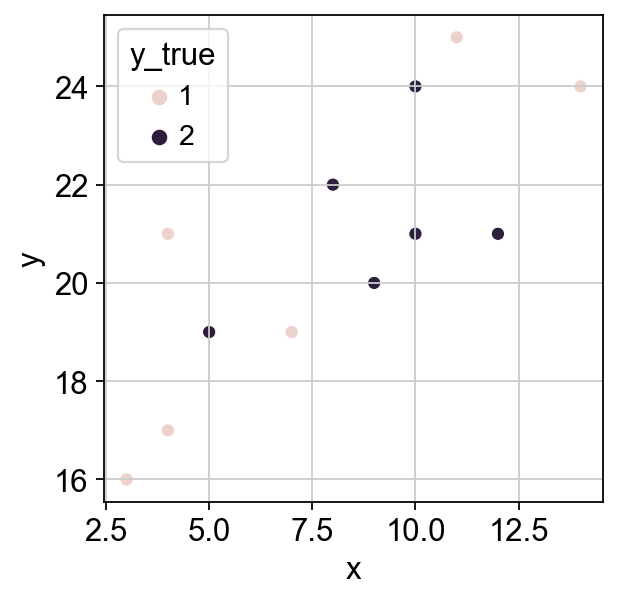

In [300]:
import matplotlib.pyplot as plt

x = [4, 5, 10, 4, 3, 11, 14, 8, 10, 12, 9, 7]
y = [21, 19, 24, 17, 16, 25, 24, 22, 21, 21, 20, 19]
y_true = [1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1]

df = pd.DataFrame(list(zip(x, y, y_true)), columns=["x", "y", "y_true"])

sns.scatterplot(data=df, x="x", y="y", hue="y_true")

In [301]:
from sklearn.cluster import KMeans

data = list(zip(x, y))
inertias = []

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

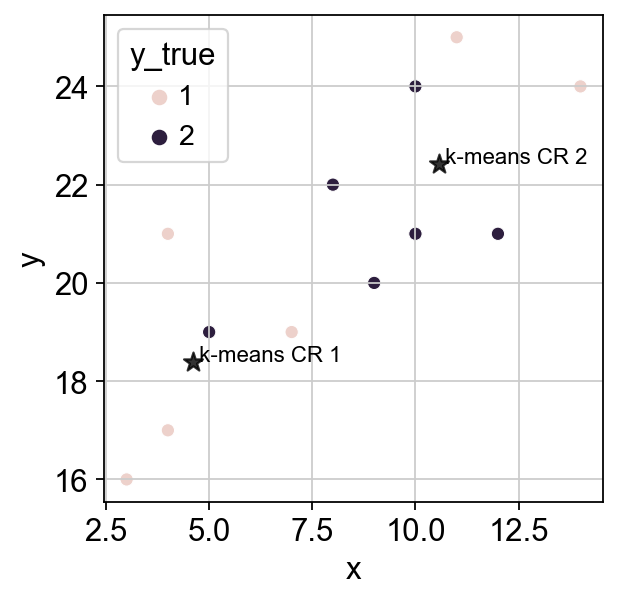

In [302]:
sns.scatterplot(data=df, x="x", y="y", hue="y_true")
centroid_id = 1
for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color="black")
    plt.text(centroid[0], centroid[1], f" k-means CR {centroid_id}", color="black", fontsize=10)
    centroid_id += 1

In [303]:
df

,x,y,y_true
0,4,21,1
1,5,19,2
2,10,24,2
3,4,17,1
4,3,16,1
5,11,25,1
6,14,24,1
7,8,22,2
8,10,21,2
9,12,21,2


Training dataset trnasforming into a new feature space, where features CA and CB encode the distance from each training example to a given cluster representative (centroids)

<AxesSubplot: xlabel='dist_centorid_0', ylabel='dist_centorid_1'>

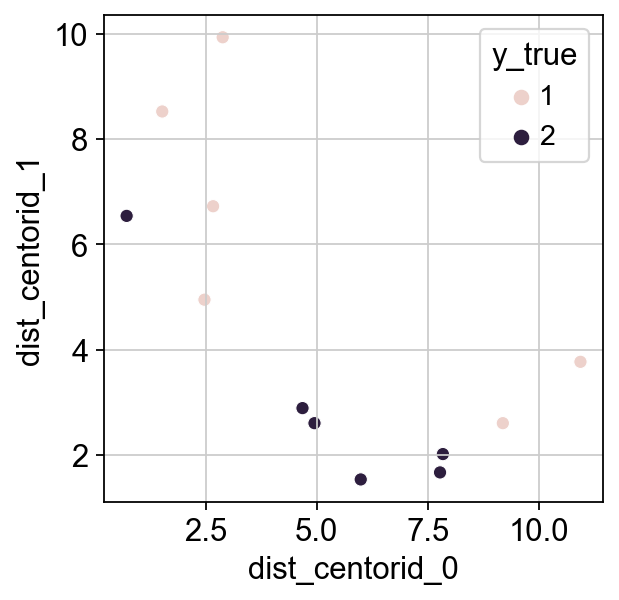

In [304]:
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df.iterrows():
        coord = np.array([row["x"], row["y"]])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)

    # Add dinstances between each row and selected centroid to existing df.
    df[f"dist_centorid_{i}"] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sns.scatterplot(data=df, x="dist_centorid_0", y="dist_centorid_1", hue="y_true")

In [306]:
df

,x,y,y_true,dist_centorid_0,dist_centorid_1
0,4,21,1,2.668333,6.724916
1,5,19,2,0.721110,6.541859
2,10,24,2,7.779460,1.672100
3,4,17,1,1.523155,8.523677
4,3,16,1,2.884441,9.932425
5,11,25,1,9.193476,2.606898
6,14,24,1,10.941663,3.771537
7,8,22,2,4.951767,2.606898
8,10,21,2,5.993330,1.538619
9,12,21,2,7.843469,2.020305


In [314]:
from sklearn.svm import SVC

# Let's see target names
targets = df.y_true.unique()
print("Target labels:", targets)

# Prepare training data for building the model
X_train = df.drop(["y_true"], axis=1)
y_train = df["y_true"]

# Instantiate the model
cls = SVC()
# Train/Fit the model
cls.fit(X_train, y_train)

Target labels: [1 2]


SVC()

In [315]:
# Make prediction using the model
x_new_sample = [-1]
y_new_sample = [0.5]
df_new = pd.DataFrame(list(zip(x_new_sample, y_new_sample)), columns=["x", "y"])

# Get distance between a new sample and existing centroids
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row["x"], row["y"]])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)

    # Add dinstances between each row and selected centroid to existing df.
    df_new[f"dist_centorid_{i}"] = temp_dist_sample_centroids

# Run prediction
for index, row in df_new.iterrows():
    X_pred = row.to_list()
    y_pred = cls.predict([X_pred])

    print("Prediction is: {}".format(targets[y_pred]))

Prediction is: [2]


/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


#### Test of k-mean clusterning with multi-feature (columns) dataset

In [291]:
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, _ = make_blobs(n_samples=10, centers=3, n_features=4)

df = pd.DataFrame(X, columns=["Feat_1", "Feat_2", "Feat_3", "Feat_4"])

kmeans = KMeans(n_clusters=3)

y = kmeans.fit_predict(df[["Feat_1", "Feat_2", "Feat_3", "Feat_4"]])

df["Cluster"] = y

print(df.head())

     Feat_1    Feat_2    Feat_3     Feat_4  Cluster
0  0.411590  5.954091 -5.279112   0.182496        0
1  3.314247 -7.308889  3.345181  11.212955        1
2  0.381306 -3.835178 -7.197724   1.232849        2
3  5.749942 -8.903017  3.310046   7.614133        1
4 -1.135717  5.602969 -6.097274  -1.685105        0


### -----------------Done feasibility study!!!----------------

#### Make a dataframe (columns: UMAP1, UMAP2, sample)

In [440]:
adata.obsm["X_umap"]

array([[ 1.0045827e+01,  3.8673859e+00],
       [ 2.4835434e+00,  1.4139254e+00],
       [ 2.1057522e+00,  1.8702780e+00],
       ...,
       [ 5.0757337e+00,  1.0330786e+01],
       [ 5.7447367e+00,  9.3942690e+00],
       [-1.3380613e-03,  1.2514826e+01]], dtype=float32)

In [441]:
umap1 = adata.obsm["X_umap"][:, 0]
umap2 = adata.obsm["X_umap"][:, 1]
sample_vector = adata.obs["sample"].values

df = pd.DataFrame(list(zip(umap1, umap2, sample_vector)), columns=["umap1", "umap2", "sample"])
df

,umap1,umap2,sample
0,10.045827,3.867386,covid_1
1,2.483543,1.413925,covid_1
2,2.105752,1.870278,covid_1
3,1.651771,6.245513,covid_1
4,6.048353,9.246040,covid_1
...,...,...,...
5589,-3.815006,8.711981,ctrl_14
5590,-2.163753,0.430748,ctrl_14
5591,5.075734,10.330786,ctrl_14
5592,5.744737,9.394269,ctrl_14


### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.


In [442]:
list_covid_non_covid = []
for index, row in df.iterrows():
    if "covid" in row["sample"] or "COVID" in row["sample"]:
        list_covid_non_covid.append("covid")
    else:
        list_covid_non_covid.append("non_covid")

df["covid_non_covid"] = list_covid_non_covid
df

,umap1,umap2,sample,covid_non_covid
0,10.045827,3.867386,covid_1,covid
1,2.483543,1.413925,covid_1,covid
2,2.105752,1.870278,covid_1,covid
3,1.651771,6.245513,covid_1,covid
4,6.048353,9.246040,covid_1,covid
...,...,...,...,...
5589,-3.815006,8.711981,ctrl_14,non_covid
5590,-2.163753,0.430748,ctrl_14,non_covid
5591,5.075734,10.330786,ctrl_14,non_covid
5592,5.744737,9.394269,ctrl_14,non_covid


#### Split the dataset into train: df_exist and test: df_new

In [443]:
list_samples = df["sample"].unique()

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=110)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)  # 4 samples
print("Samples for testing:", y_test)  # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['ctrl_13' 'covid_15' 'ctrl_5' 'covid_1']
Samples for testing: ['ctrl_14' 'covid_17']


In [444]:
# Make a dataframe for training
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
df_exist

,umap1,umap2,sample,covid_non_covid
0,10.045827,3.867386,covid_1,covid
1,2.483543,1.413925,covid_1,covid
2,2.105752,1.870278,covid_1,covid
3,1.651771,6.245513,covid_1,covid
4,6.048353,9.246040,covid_1,covid
...,...,...,...,...
4601,0.020649,2.082641,ctrl_13,non_covid
4602,10.482266,3.445403,ctrl_13,non_covid
4603,0.277890,12.749501,ctrl_13,non_covid
4604,4.574630,8.211782,ctrl_13,non_covid


In [445]:
# Make a dataframe for testing
y_test = list(y_test)
df_new = df.query("sample == @y_test")
df_new

,umap1,umap2,sample,covid_non_covid
1435,-6.352292,1.221819,covid_17,covid
1436,-5.930367,2.221649,covid_17,covid
1437,-5.994318,2.669503,covid_17,covid
1438,-6.251666,2.748733,covid_17,covid
1439,13.166336,1.604708,covid_17,covid
...,...,...,...,...
5589,-3.815006,8.711981,ctrl_14,non_covid
5590,-2.163753,0.430748,ctrl_14,non_covid
5591,5.075734,10.330786,ctrl_14,non_covid
5592,5.744737,9.394269,ctrl_14,non_covid


### Run Kmeans clusterning to get clusters' centroids as a cluster representation.

Also, check the elbow to determine the number of clusters (the parameter `k`).

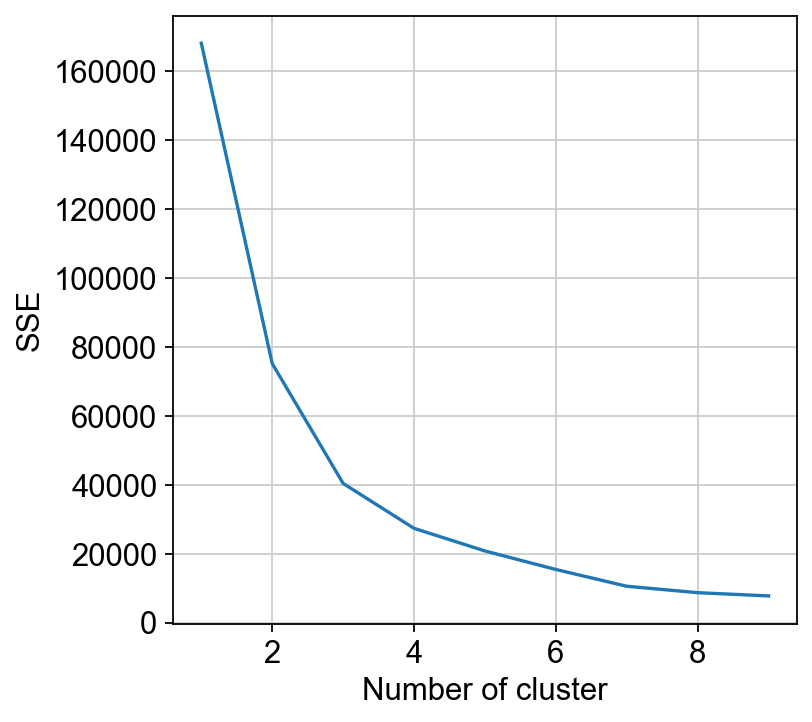

In [446]:
from sklearn.cluster import KMeans

data = df_exist[["umap1", "umap2"]]
inertias = []

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data)
    sse[k] = kmeans.inertia_  # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

According to the above plot, we shall use `k=3` this time.<br>
<br>

Next, train a kmeans again with `k=3`, and get distances between each centroid and each sample, and then append them to the dataframe.

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_72189/80270127.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_72189/80270127.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_72189/80270127.py:19: SettingWithCopyWarning: 
A value is trying to be set on a

<AxesSubplot: xlabel='dist_centorid_0', ylabel='dist_centorid_1'>

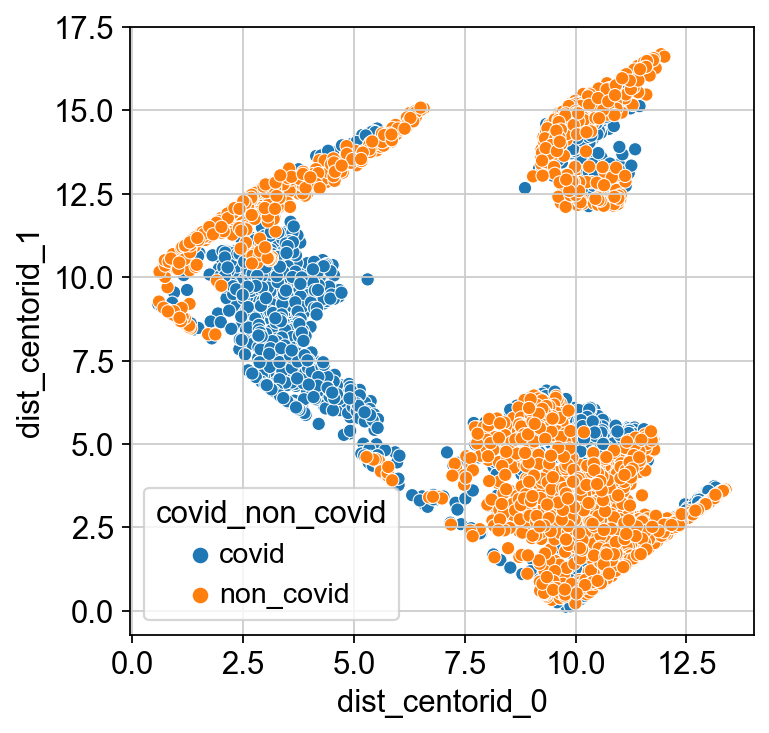

In [447]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

### Compute a distance
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row["umap1"], row["umap2"]])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)

    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f"dist_centorid_{i}"] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_1", hue="covid_non_covid")

Also, print the augmented dataframe.

In [448]:
df_exist

,umap1,umap2,sample,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2
0,10.045827,3.867386,covid_1,covid,10.313922,12.153714,2.707544
1,2.483543,1.413925,covid_1,covid,2.425700,9.895108,7.711724
2,2.105752,1.870278,covid_1,covid,2.127534,9.368806,8.116266
3,1.651771,6.245513,covid_1,covid,5.213134,5.008713,9.937118
4,6.048353,9.246040,covid_1,covid,9.964265,6.079682,9.082219
...,...,...,...,...,...,...,...
4601,0.020649,2.082641,ctrl_13,non_covid,0.802822,8.972177,10.211985
4602,10.482266,3.445403,ctrl_13,non_covid,10.643201,12.755450,2.300144
4603,0.277890,12.749501,ctrl_13,non_covid,11.470684,1.697798,15.248067
4604,4.574630,8.211782,ctrl_13,non_covid,8.270797,5.179694,9.012254


Train the augmented dataset in SVM

In [449]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(["sample", "covid_non_covid"], axis=1)
y_train = df_exist["covid_non_covid"]

# Instantiate the model
cls = SVC()
# Train/Fit the model
cls.fit(X_train, y_train)

SVC()

Print the dataframe for the test data/new samples

In [450]:
df_new

,umap1,umap2,sample,covid_non_covid
1435,-6.352292,1.221819,covid_17,covid
1436,-5.930367,2.221649,covid_17,covid
1437,-5.994318,2.669503,covid_17,covid
1438,-6.251666,2.748733,covid_17,covid
1439,13.166336,1.604708,covid_17,covid
...,...,...,...,...
5589,-3.815006,8.711981,ctrl_14,non_covid
5590,-2.163753,0.430748,ctrl_14,non_covid
5591,5.075734,10.330786,ctrl_14,non_covid
5592,5.744737,9.394269,ctrl_14,non_covid


In [452]:
# Get distance between a new sample and existing centroids
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row["umap1"], row["umap2"]])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)

    # Add dinstances between each row and selected centroid to existing df.
    df_new[f"dist_centorid_{i}"] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(["sample", "covid_non_covid"], axis=1)
y_test = df_new["covid_non_covid"]
y_pred = cls.predict(X_test)

df_new["y_pred"] = y_pred

/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_72189/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_72189/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/var/folders/_v/_8q_jx1d5yvb945rch5712vm0000gn/T/ipykernel_72189/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a 

In [453]:
df_new

,umap1,umap2,sample,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,y_pred
1435,-6.352292,1.221819,covid_17,covid,6.414059,11.837777,16.543601,non_covid
1436,-5.930367,2.221649,covid_17,covid,6.065271,10.774414,16.156248,non_covid
1437,-5.994318,2.669503,covid_17,covid,6.212987,10.448577,16.255416,non_covid
1438,-6.251666,2.748733,covid_17,covid,6.481564,10.541696,16.519088,non_covid
1439,13.166336,1.604708,covid_17,covid,13.108841,16.008191,3.007629,covid
...,...,...,...,...,...,...,...,...
5589,-3.815006,8.711981,ctrl_14,non_covid,8.381458,4.684473,15.910684,non_covid
5590,-2.163753,0.430748,ctrl_14,non_covid,2.382104,10.890604,12.376685,non_covid
5591,5.075734,10.330786,ctrl_14,non_covid,10.346196,4.886151,10.497746,non_covid
5592,5.744737,9.394269,ctrl_14,non_covid,9.905890,5.745968,9.354816,non_covid


In [458]:
pred_label_count = {
    key: [
        0,
        0,
    ]
    for key in df_new["sample"].unique()
}  # [count_covid, count_non_covid]

for index, row in df_new.iterrows():
    if "covid" == row["y_pred"]:
        pred_label_count[row["sample"]][0] += 1
    else:
        pred_label_count[row["sample"]][1] += 1

print("pred_label_count:", pred_label_count)

y_pred = []
y_true = []

# Finalize the output, get the label with the highest counts
for sample, counts in pred_label_count.items():
    if counts[0] > counts[1]:  # counts of covid > counts of non_covid
        y_pred.append("covid")
    else:
        y_pred.append("non_covid")

    if "covid" in sample or "COVID" in sample:
        y_true.append("covid")
    else:
        y_true.append("non_covid")

pred_label_count: {'covid_17': [186, 842], 'ctrl_14': [79, 909]}


In [461]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_true, y_pred, average="micro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_true, y_pred, average="micro"))

Accuracy: 0.5
Precision: 0.5
Recall: 0.5
